In [1]:
import os, gzip, pandas as pd
from collections import defaultdict
import numpy as np
import scipy.io
import pysam

RUN = os.path.expanduser("~/sample_GRCh38")   #결과 파일 경로 지정 (각 파일 형태가 달라서)
OUT = os.path.join(RUN, "outs")      
BAM = os.path.join(OUT, "possorted_genome_bam.bam")  # read alignmnet result
BAR = os.path.join(OUT, "filtered_feature_bc_matrix", "barcodes.tsv.gz") #barcode list (singlet - positive result)
FEA = os.path.join(OUT, "filtered_feature_bc_matrix", "features.tsv.gz") #feature information (gene ID, gene name etc..)
MTX = os.path.join(OUT, "filtered_feature_bc_matrix", "matrix.mtx.gz")  #sparse matrix

for p in [BAM, BAR, FEA, MTX]:
    assert os.path.exists(p), f"파일이 없습니다: {p}"

bam = pysam.AlignmentFile(BAM, "rb")

# barcodes, features 로드
barcodes = [line.strip() for line in gzip.open(BAR, "rt")]
feat_rows = [line.strip().split("\t") for line in gzip.open(FEA, "rt")]
# features.tsv는 [gene_id, gene_name, feature_type] 3열
feat_df = pd.DataFrame(feat_rows, columns=["gene_id","gene_name","feature_type"])

# matrix.mtx (CSR) 로드
mtx = scipy.io.mmread(MTX).tocsr()  # (n_barcodes x n_features)
print(mtx.shape, len(barcodes), len(feat_df))

(38606, 1221) 1221 38606


In [2]:
# 몇 개 리드만 태그 보기
cnt = 0
for read in bam.fetch(until_eof=True):
    tags = dict(read.get_tags())
    has = set(tags.keys()) & {"CB","CR","UB","UR","GX","GN"}
    if has:
        print("READ:", read.query_name)
        for k in sorted(has):
            print(f"  {k}:", tags[k])
        cnt += 1
    if cnt >= 3:
        break


READ: A00228:279:HFWFVDMXX:2:1385:2085:18975
  CR: TCTGCATGTAACTTAA
  UB: TACCACAACCAG
  UR: TACCACAACCAG
READ: A00228:279:HFWFVDMXX:1:2388:30499:30827
  CB: CACTGAAGTCTTTCTA-1
  CR: CACTGAAGTCTTTCTA
  GN: DDX11L2
  GX: ENSG00000290825
  UB: GCCTTACAGGTC
  UR: GCCTTACAGGTC
READ: A00228:279:HFWFVDMXX:1:2415:3640:8015
  CB: CACTGAAGTCTTTCTA-1
  CR: CACTGAAGTCTTTCTA
  GN: DDX11L2
  GX: ENSG00000290825
  UB: GCCTTACAGGTC
  UR: GCCTTACAGGTC


In [3]:
# 바코드 하나 고르기: (matrix에서 nonzero가 있는 바코드만 뽑기)
row_nnz = np.diff(mtx.indptr)  # 각 행의 nonzero 개수
rid = int(np.argmax(row_nnz))  # 가장 많은 유전자를 가진 셀 한 개 선택 (예시)
BC  = barcodes[rid]
print("선택 바코드:", BC, "행인덱스:", rid+1)

# 그 바코드에서 가장 카운트가 높은 유전자 한 개 선택
row_start, row_end = mtx.indptr[rid], mtx.indptr[rid+1]
cols = mtx.indices[row_start:row_end]
vals = mtx.data[row_start:row_end]
cid = int(cols[np.argmax(vals)])
VAL = int(vals.max())      # matrix 상 값(= UMI 개수)
GID = feat_df.iloc[cid, 0] # gene_id
GNAME = feat_df.iloc[cid, 1]
print("선택 유전자:", GID, GNAME, "열인덱스:", cid+1, "matrix값:", VAL)

# BAM에서 (CB=BC, GX=GID)인 read들의 UB(tag) 고유 개수 세기
umis = set()
reads_count = 0
for read in bam.fetch(until_eof=True):
    tags = dict(read.get_tags())
    if tags.get("CB")==BC and tags.get("GX")==GID:
        reads_count += 1
        ub = tags.get("UB")
        if ub:
            umis.add(ub)

print("BAM read 개수:", reads_count)
print("BAM 고유 UMI 개수:", len(umis))
print("일치 검증 -> matrix =", VAL, ", BAM UMI =", len(umis))


IndexError: list index out of range

In [4]:
diff_examples = []
for read in bam.fetch(until_eof=True):
    tags = dict(read.get_tags())
    cb, cr = tags.get("CB"), tags.get("CR")
    ub, ur = tags.get("UB"), tags.get("UR")
    if cb and cr and cb != cr:
        diff_examples.append(("CB!=CR", read.query_name, cr, cb))
    if ub and ur and ub != ur:
        diff_examples.append(("UB!=UR", read.query_name, ur, ub))
    if len(diff_examples) >= 5:
        break

pd.DataFrame(diff_examples, columns=["type","read_id","raw","corrected"])


,type,read_id,raw,corrected
0,CB!=CR,A00228:279:HFWFVDMXX:1:2317:2790:31093,CACTGAAGTCTTTCTA,CACTGAAGTCTTTCTA-1
1,CB!=CR,A00228:279:HFWFVDMXX:2:2166:6289:9565,CACTGAAGTCTTTCTA,CACTGAAGTCTTTCTA-1
2,CB!=CR,A00228:279:HFWFVDMXX:1:1276:28908:3991,TACCGGGTCCTCGATC,TACCGGGTCCTCGATC-1
3,CB!=CR,A00228:279:HFWFVDMXX:2:1481:8359:5447,GTGTTCCGTAGTTCCA,GTGTTCCGTAGTTCCA-1
4,CB!=CR,A00228:279:HFWFVDMXX:2:1126:28537:34350,AGGTGTTAGCAATTAG,AGGTGTTAGCAATTAG-1


Cell Ranger 결과 디렉토리 구조를 따라 파일 경로를 지정함.

outs/ 안에 주요 결과들이 들어 있음:

possorted_genome_bam.bam: read alignment 결과 (각 read가 genome 어디에 붙었는지)

barcodes.tsv.gz: 유효 세포(barcode) 리스트

features.tsv.gz: feature 정보 (유전자 ID, 유전자명, feature 종류)

matrix.mtx.gz: 유전자 × barcode sparse matrix

In [5]:
# 상위 N개의 바코드 × 각 바코드 상위 M 유전자에 대해
N, M = 5, 5
top_rows = np.argsort(row_nnz)[-N:][::-1]

def bam_umi_count_for(BC, GID, max_scan=3_000_000):
    umis, reads = set(), 0
    i = 0
    for read in bam.fetch(until_eof=True):
        i += 1
        tags = dict(read.get_tags())
        if tags.get("CB")==BC and tags.get("GX")==GID:
            reads += 1
            ub = tags.get("UB")
            if ub: umis.add(ub)
        if i >= max_scan:
            break
    return reads, len(umis)

rows = []
for rid in top_rows:
    BC = barcodes[rid]
    rs, re = mtx.indptr[rid], mtx.indptr[rid+1]
    cols, vals = mtx.indices[rs:re], mtx.data[rs:re]
    top_cidx = cols[np.argsort(vals)[-M:][::-1]]
    for cid in top_cidx:
        GID, GNAME = feat_df.iloc[cid, 0], feat_df.iloc[cid, 1]
        VAL = int(mtx[rid, cid])
        reads_n, umis_n = bam_umi_count_for(BC, GID)  # 주의: 큰 BAM에선 느릴 수 있음
        rows.append([BC, GID, GNAME, VAL, reads_n, umis_n])

report = pd.DataFrame(rows, columns=["barcode","gene_id","gene","matrix_val(UMI)","reads_in_BAM","UMI_in_BAM"])
report


IndexError: list index out of range

# 흐름 요약 (주피터에서 무엇을 확인하나)

## BAM 태그 미리보기 → Cell Ranger가 바코드/UMI/유전자 태그를 어떻게 붙였는지 감 잡기

(바코드, 유전자) 한 쌍 선택 →

BAM에서 UB 고유개수 세기 ↔ matrix.mtx의 값 대조 (동일해야 함)

CR/UR ↔ CB/UB 비교 → 화이트리스트/오류교정이 실제로 어떻게 적용됐는지 확인

(선택) 다수 셀/유전자에 대해 일괄 리포트로 검증

## Load data

In [30]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

sc.__version__

'1.11.4'

In [16]:
adata = sc.read_10x_h5('/home/r22100180/sample_GRCh38/outs/filtered_feature_bc_matrix.h5')
adata

/home/r22100180/yes/envs/cell_code/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/r22100180/yes/envs/cell_code/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1221 × 38606
    var: 'gene_ids', 'feature_types', 'genome'

In [17]:
adata.var_names_make_unique()

In [18]:
adata

AnnData object with n_obs × n_vars = 1221 × 38606
    var: 'gene_ids', 'feature_types', 'genome'

## The count data matrix

In [20]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 4099222 stored elements and shape (1221, 38606)>

In [21]:
adata.X.data

array([ 1.,  1.,  3., ..., 29., 11., 42.], shape=(4099222,), dtype=float32)

In [22]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1221, 38606), dtype=float32)

## Cell barcodes

In [23]:
adata.obs

""
AAACCCAAGGAGAGTA-1
AAACGCTTCAGCCCAG-1
AAAGAACAGACGACTG-1
AAAGAACCAATGGCAG-1
AAAGAACGTCTGCAAT-1
...
TTTCCTCTCTCTTGCG-1
TTTGATCTCTTTGGAG-1
TTTGGTTAGTAACCTC-1
TTTGGTTGTAGAATAC-1


In [24]:
type(adata.obs)

pandas.core.frame.DataFrame

## Genes

In [25]:
adata.var

,gene_ids,feature_types,genome
DDX11L2,ENSG00000290825,Gene Expression,GRCh38
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
ENSG00000290826,ENSG00000290826,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
...,...,...,...
ENSG00000277836,ENSG00000277836,Gene Expression,GRCh38
ENSG00000278633,ENSG00000278633,Gene Expression,GRCh38
ENSG00000276017,ENSG00000276017,Gene Expression,GRCh38
ENSG00000278817,ENSG00000278817,Gene Expression,GRCh38


In [26]:
type(adata.var)

pandas.core.frame.DataFrame

## Sparsity affects gene-gene relationships

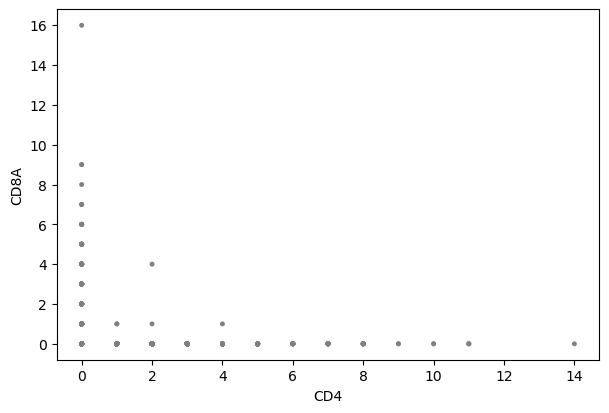

In [27]:
sc.pl.scatter(adata, x = 'CD4', y = 'CD8A', size = 50)

In [28]:
from scipy.stats import gaussian_kde

x = adata[:, 'CD4'].X.toarray().flatten()
y = adata[:, 'CD8A'].X.toarray().flatten()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

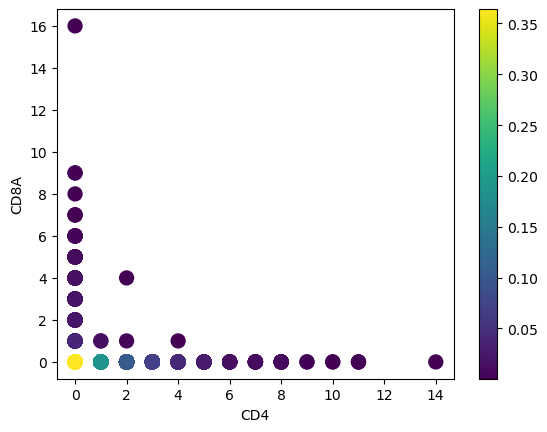

In [31]:
fig, ax = plt.subplots()
im1 = ax.scatter(x, y, c=z, s=100)
ax.set_xlabel('CD4')
ax.set_ylabel('CD8A')
fig.colorbar(im1)
plt.show()


## Calculate QC metrics

In [32]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [33]:
adata

AnnData object with n_obs × n_vars = 1221 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [34]:
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCCAAGGAGAGTA-1,3918,8.273592,12958.0,9.469545,23.668776,30.861244,39.720636,54.661213
AAACGCTTCAGCCCAG-1,3293,8.099858,9527.0,9.161990,23.375669,32.780519,42.920122,58.087541
AAAGAACAGACGACTG-1,2667,7.889084,6601.0,8.795128,25.768823,34.964399,44.266020,59.763672
AAAGAACCAATGGCAG-1,2155,7.676010,4419.0,8.393895,23.082145,31.093007,41.072641,57.773252
AAAGAACGTCTGCAAT-1,3203,8.072155,10004.0,9.210840,28.698521,39.724110,48.930428,62.594962


In [35]:
adata.var.head()

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
DDX11L2,ENSG00000290825,Gene Expression,GRCh38,1,0.000819,0.000819,99.9181,1.0,0.693147
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,0,0.000000,0.000000,100.0000,0.0,0.000000
FAM138A,ENSG00000237613,Gene Expression,GRCh38,0,0.000000,0.000000,100.0000,0.0,0.000000
ENSG00000290826,ENSG00000290826,Gene Expression,GRCh38,0,0.000000,0.000000,100.0000,0.0,0.000000
OR4F5,ENSG00000186092,Gene Expression,GRCh38,0,0.000000,0.000000,100.0000,0.0,0.000000


## Visualize library size

Text(0, 0.5, 'Frequency')

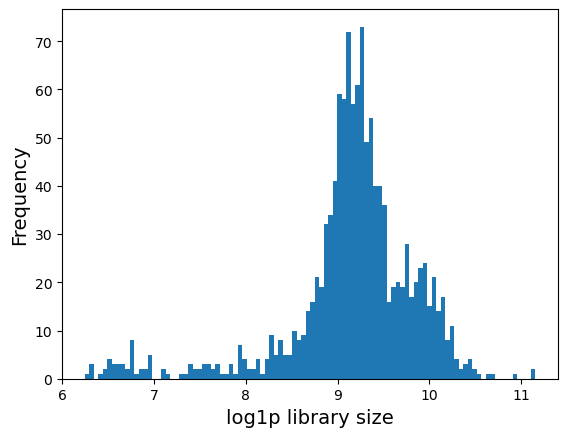

In [36]:
plt.hist(adata.obs['log1p_total_counts'], 100);
plt.xlabel('log1p library size', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

## Visualize the number of genes in each cell

Text(0, 0.5, 'Frequency')

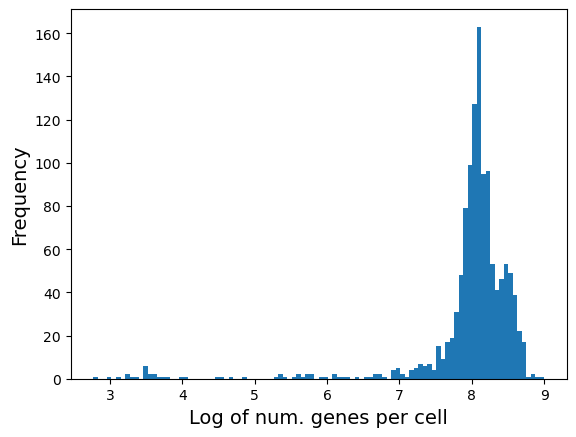

In [37]:
plt.hist(adata.obs['log1p_n_genes_by_counts'], bins = 100);
plt.xlabel('Log of num. genes per cell', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
#plt.title('Histogram of number of genes expressed in each cell', fontsize = 14)

Text(0.5, 1.0, 'Correlation = 0.88')

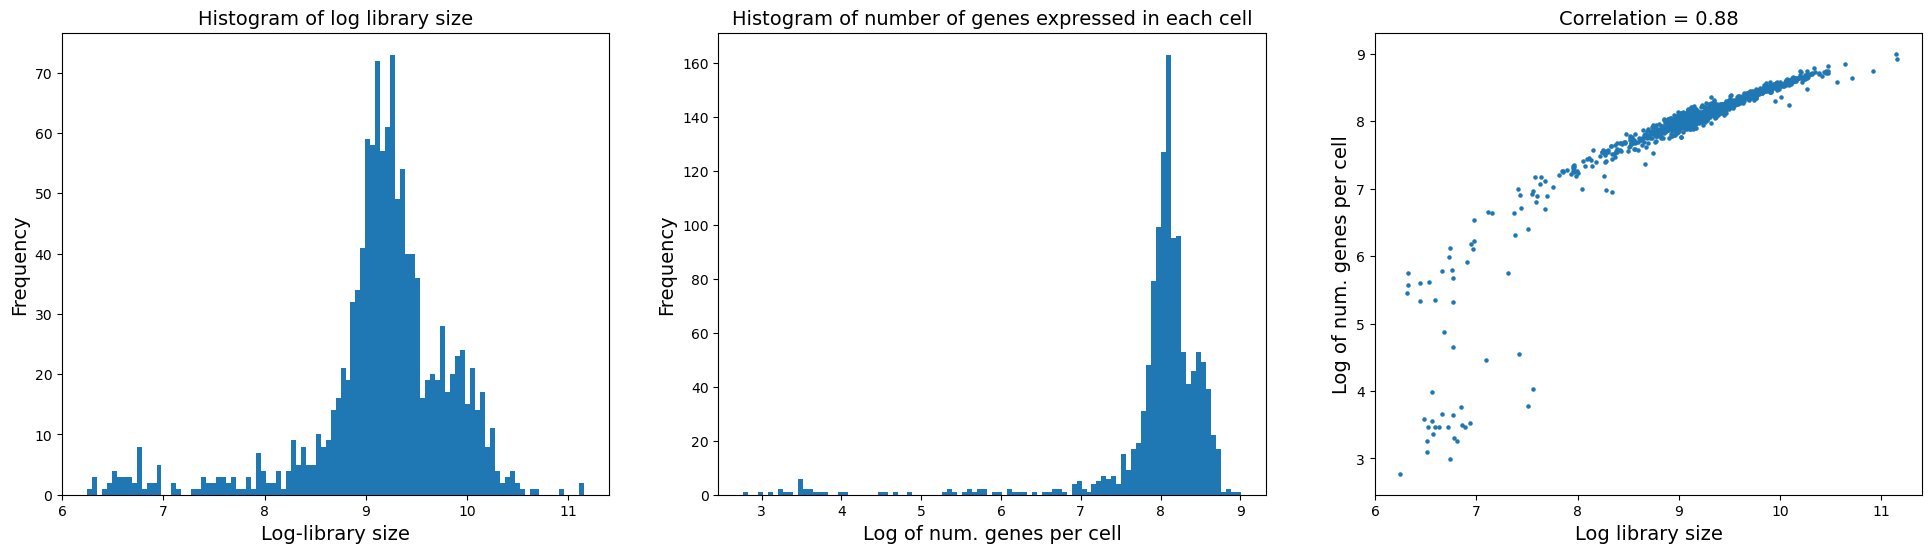

In [38]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['log1p_total_counts'], bins = 100);
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log library size', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(adata.obs['log1p_n_genes_by_counts'], bins = 100);
ax.set_xlabel('Log of num. genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of genes expressed in each cell', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
x = adata.obs['log1p_total_counts']
y = adata.obs['log1p_n_genes_by_counts']
ax.scatter(x, y, s = 5);
ax.set_ylabel('Log of num. genes per cell', fontsize = 14)
ax.set_xlabel('Log library size', fontsize = 14)
corr_coef = np.corrcoef(x, y)[0, 1]
ax.set_title('Correlation = ' + str(round(corr_coef, 3)), fontsize = 14)

## Mitochondrial content

In [39]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [40]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [41]:
adata

AnnData object with n_obs × n_vars = 1221 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

### Visualize Mito-content

Text(0, 0.5, '% MT-content')

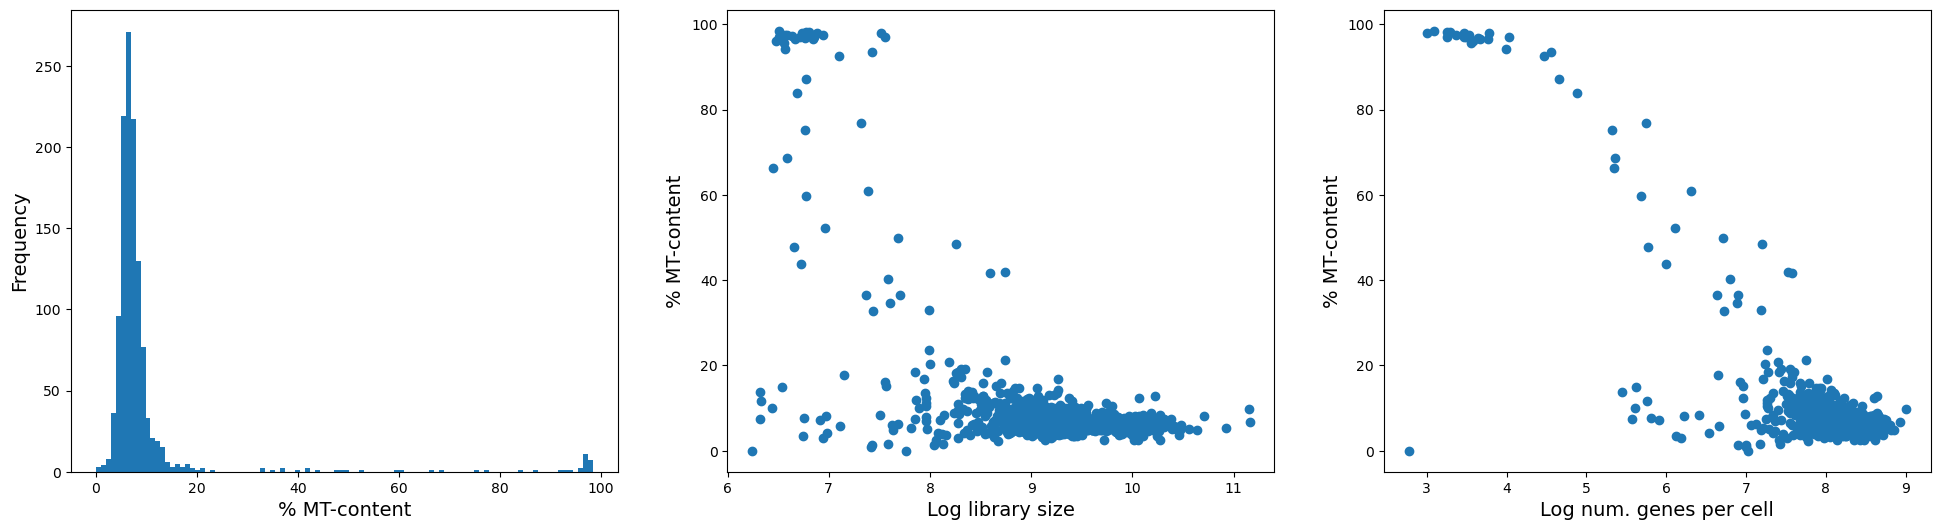

In [42]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['pct_counts_mt'], 100);
ax.set_xlabel('% MT-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs['log1p_total_counts'], adata.obs['pct_counts_mt']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs['log1p_n_genes_by_counts'], adata.obs['pct_counts_mt']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

In [43]:
adata_clean = adata[adata.obs['pct_counts_mt'] < 25, :]

In [44]:
adata_clean

View of AnnData object with n_obs × n_vars = 1177 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

Text(0, 0.5, 'Frequency')

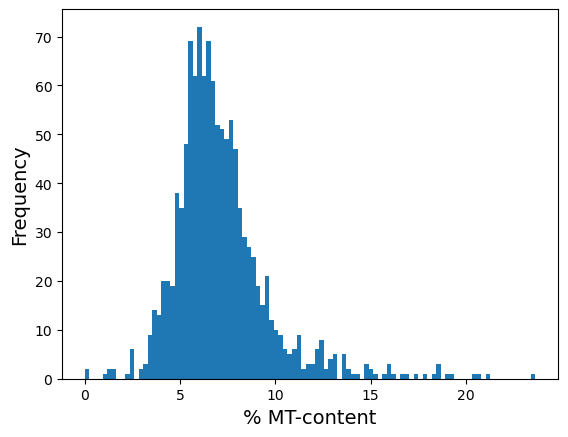

In [45]:
# just double check: there must be no cell with MT > 25
plt.hist(adata_clean.obs['pct_counts_mt'], 100);
plt.xlabel('% MT-content', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

## Plot number of genes expressed in each cell

Text(0.5, 1.0, 'Histogram of number of cells each gene is expressed in')

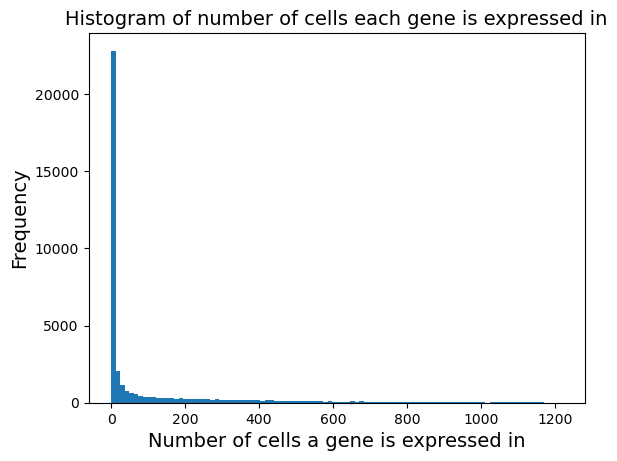

In [46]:
plt.hist(adata_clean.var['n_cells_by_counts'], bins = 100);
plt.xlabel('Number of cells a gene is expressed in', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of number of cells each gene is expressed in', fontsize = 14)

(0.0, 1000.0)

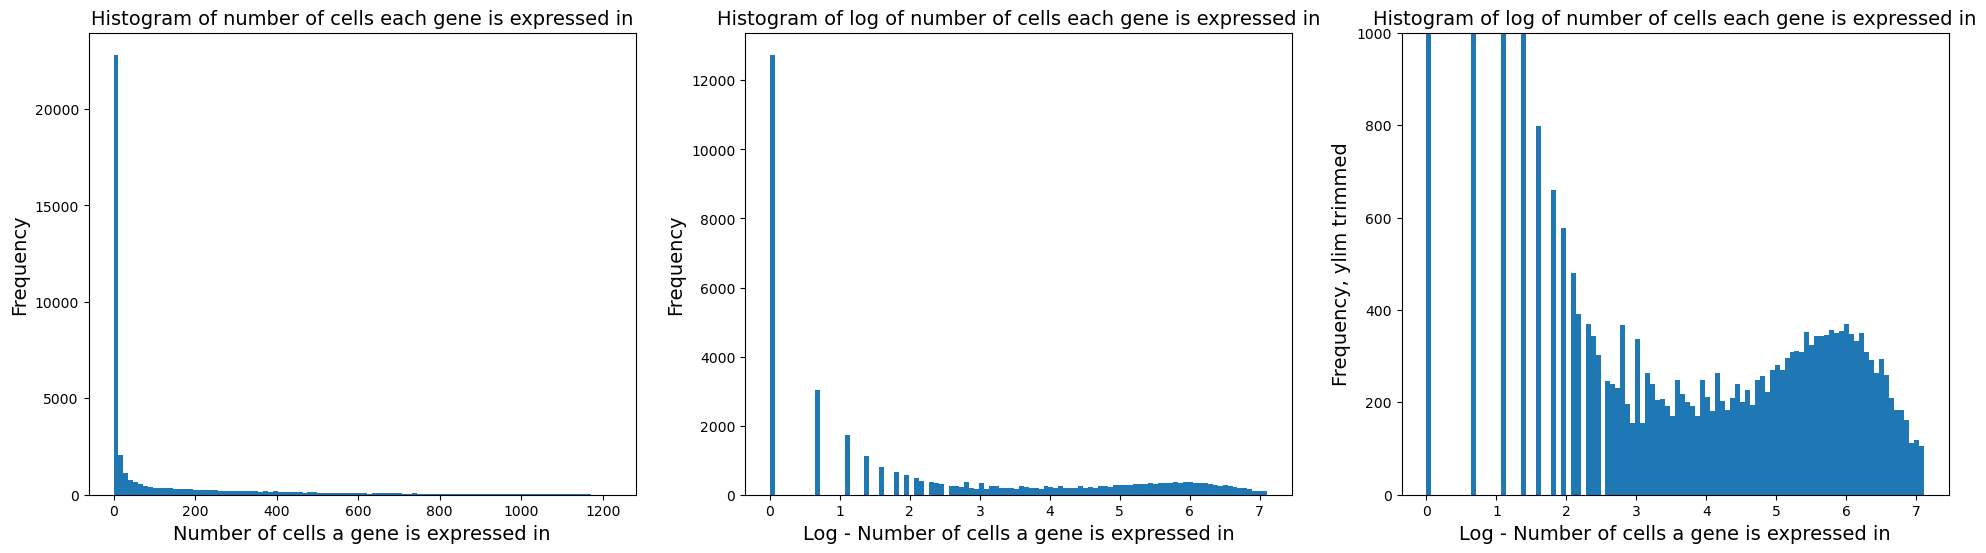

In [47]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata_clean.var['n_cells_by_counts'], bins = 100);
ax.set_xlabel('Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(adata_clean.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(adata_clean.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency, ylim trimmed', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)
ax.set_ylim([0, 1000])

### Remove lowly expressed genes

In [48]:
sc.pp.filter_genes(adata_clean, min_cells = np.exp(4))

/home/r22100180/yes/envs/cell_code/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [49]:
adata_clean

AnnData object with n_obs × n_vars = 1177 × 11424
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'

## Ribosomal RNA content

In [50]:
adata_clean.var_names[adata_clean.var_names.str.startswith(('RPS', 'RPL'))]

Index(['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7',
       'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29',
       'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-DT', 'RPL34',
       'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10',
       'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS20', 'RPL7', 'RPL30',
       'RPL8', 'RPS6', 'RPL35', 'RPL12', 'RPL7A', 'RPS24', 'RPLP2', 'RPL27A',
       'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS3', 'RPS25', 'RPS26', 'RPL41',
       'RPL6', 'RPLP0', 'RPL21', 'RPS29', 'RPL36AL', 'RPS6KA5', 'RPS27L',
       'RPL4', 'RPLP1', 'RPS17', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A',
       'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17', 'RPS15',
       'RPL36', 'RPS28', 'RPL18A', 'RPSA2', 'RPS16', 'RPS19', 'RPL18',
       'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5', 'RPS21', 'RPL3', 'RPS19BP1',
       'RPL23AP7', 'RPS6KA3', 'RPS4X', 'RPL36A', 'RPL39', 'RPL10', 'RPS4Y1'],
      dtype='o

In [51]:
adata_clean = adata_clean[:, ~adata_clean.var_names.str.startswith(('RPS', 'RPL'))]

In [52]:
adata_clean

View of AnnData object with n_obs × n_vars = 1177 × 11328
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'